In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone 'https://github.com/AliM100/Ransomware_Detection.git'
!pip install patool

In [ ]:
!unzip /content/drive/MyDrive/malimg_dataset.zip -d data

In [1]:
import os
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import shutil
import pandas as pd
import patoolib
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import average_precision_score,accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import tensorflow
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from Ransomware_Detection.mal_dataset import maldataset
from Ransomware_Detection.data_conversion import convert_data
from Ransomware_Detection.dataset import load_data,prepare_data
from Ransomware_Detection.pytorch_model import CustomModel


In [2]:
class_index = {'Adialer.C': 0,
                'Agent.FYI': 1,
                'Allaple.A': 2,
                'Allaple.L': 3,
                'Alueron.gen!J': 4,
                'Autorun.K': 5,
                'C2LOP.P': 6,
                'C2LOP.gen!g': 7,
                'Dialplatform.B': 8,
                'Dontovo.A': 9,
                'Fakerean': 10,
                'Instantaccess': 11,
                'Lolyda.AA1': 12,
                'Lolyda.AA2': 13,
                'Lolyda.AA3': 14,
                'Lolyda.AT': 15,
                'Malex.gen!J': 16,
                'Obfuscator.AD': 17,
                'Rbot!gen': 18,
                'Skintrim.N': 19,
                'Swizzor.gen!E': 20,
                'Swizzor.gen!I': 21,
                'VB.AT': 22,
                'Wintrim.BX': 23,
                'Yuner.A': 24}



In [3]:
data_path="data"
img_path="data/malimg_paper_dataset_imgs"
data_csvs="data/csvs"
save_checkpoints_path="data/checkpoint"
batch_size= 10

os.makedirs(save_checkpoints_path,exist_ok=True)
os.makedirs(data_csvs,exist_ok=True)

data_prepare=prepare_data(data_path,img_path,class_index)

if not os.path.exists(f"{data_csvs}/train.csv"):
    data_prepare.create_csv_data()

target_size_custom = (224, 224)

transform = transforms.Compose([
    transforms.Resize(target_size_custom),
    # transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize((0.5,), (0.5,))])

training_set=maldataset(csv_file=f"{data_csvs}/train.csv",root_dir=img_path, class_index=class_index, transform=transform)
validation_set=maldataset(csv_file=f"{data_csvs}/val.csv",root_dir=img_path, class_index=class_index, transform=transform)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)


classes = ('Adialer.C','Agent.FYI','Allaple.A','Allaple.L','Alueron.gen!J','Autorun.K','C2LOP.P','C2LOP.gen!g','Dialplatform.B','Dontovo.A',
           'Fakerean','Instantaccess','Lolyda.AA1','Lolyda.AA2','Lolyda.AA3','Lolyda.AT','Malex.gen!J','Obfuscator.AD','Rbot!gen','Skintrim.N',
           'Swizzor.gen!E','Swizzor.gen!I','VB.AT','Wintrim.BX','Yuner.A')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


model = CustomModel(num_classes=25,target_size_custom = (224, 224)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)


def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    all_true_labels = []
    all_predicted_labels = []
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting

    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.float())

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    # scheduler.step(loss)
    train_accuracy = accuracy_score(all_true_labels, all_predicted_labels)

    return last_loss, train_accuracy

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
checkpoint="checkpoints"
os.makedirs(checkpoint,exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.
best_accuracy=0
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, train_accuracy = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    val_true_labels = []
    val_predicted_labels = []
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs.float())
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

            _, predicted = torch.max(voutputs, 1)
            val_true_labels.extend(vlabels.cpu().numpy())
            val_predicted_labels.extend(predicted.cpu().numpy())


    avg_vloss = running_vloss / (i + 1)
    val_accuracy = accuracy_score(val_true_labels, val_predicted_labels)

    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('Accuracy train {} valid {}'.format(train_accuracy, val_accuracy))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.add_scalars('Training vs. Validation Accuracy',
                { 'Training' : train_accuracy, 'Validation' : val_accuracy },
                epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if val_accuracy > best_accuracy :#or avg_vloss < best_vloss:
        #best_vloss = avg_vloss
        best_accuracy = val_accuracy
        model_path = 'checkpoints/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 0.0 valid 0.6313334107398987
Accuracy train 0.6823759558954294 valid 0.9133476856835306
EPOCH 2:
LOSS train 0.0 valid 0.3874874711036682
Accuracy train 0.8669749244175707 valid 0.9456404736275565
EPOCH 3:
LOSS train 0.0 valid 0.21297726035118103
Accuracy train 0.9151698381646808 valid 0.9531754574811625
EPOCH 4:
LOSS train 0.0 valid 0.15660953521728516
Accuracy train 0.9381113284723457 valid 0.9677072120559742
EPOCH 5:
LOSS train 0.0 valid 0.13065221905708313
Accuracy train 0.945758491908234 valid 0.9671689989235738
EPOCH 6:
LOSS train 0.0 valid 0.10234937071800232
Accuracy train 0.951627245242753 valid 0.9671689989235738
EPOCH 7:
LOSS train 0.0 valid 0.09679097682237625
Accuracy train 0.9583852036279566 valid 0.9736275565123789
EPOCH 8:
LOSS train 0.0 valid 0.08686784654855728
Accuracy train 0.9631869109016539 valid 0.9693218514531755
EPOCH 9:
LOSS train 0.0 valid 0.07999642193317413
Accuracy train 0.9596300906989151 valid 0.9703982777179763
EPOCH 10:
LOSS train 0.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [7]:
transform = transforms.Compose([
    transforms.Resize(target_size_custom),
    # transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize((0.5,), (0.5,))
    ])

test_set=maldataset(csv_file=f"{data_csvs}/test.csv",root_dir=img_path, class_index=class_index, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


model = CustomModel(num_classes=25,target_size_custom = (224, 224)).to(device)
model.load_state_dict(torch.load("drive/MyDrive/checkpoints/model_20240319_110832_37"), strict=False)

running_testloss=0.0
model.eval()
test_true_labels = []
test_predicted_labels = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, y_gt = inputs.to(device), labels.to(device)

        y_test_predicted = model(inputs.float())
        test_loss = loss_fn(y_test_predicted, y_gt)
        print(test_loss)
        running_testloss += test_loss.item()

        _, predicted = torch.max(y_test_predicted, 1)
        print(predicted)
        test_true_labels.extend(labels.cpu().numpy())
        test_predicted_labels.extend(predicted.cpu().numpy())

    avg_testloss = running_testloss / (i + 1)
    test_accuracy = accuracy_score(test_true_labels, test_predicted_labels)

    IoU=metrics.jaccard_score(test_true_labels, test_predicted_labels,average="micro")
    f1=metrics.f1_score(test_true_labels, test_predicted_labels,average="micro")
    print("micro IoU",IoU)
    print("micro f1",f1)

    IoU=metrics.jaccard_score(test_true_labels, test_predicted_labels,average="macro")
    f1=metrics.f1_score(test_true_labels, test_predicted_labels,average="macro")
    print("macro IoU",IoU)
    print("macro f1",f1)

    print('LOSS test{}, Accuracy test{}'.format(avg_testloss,test_accuracy))



tensor(0.0001, device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor(0.0001, device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor(0.0022, device='cuda:0')
tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor(0.0004, device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor(0.0004, device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 2], device='cuda:0')
tensor(0.0005, device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor(0.0008, device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor(0.0027, device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor(0.0006, device='cuda:0')


In [8]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

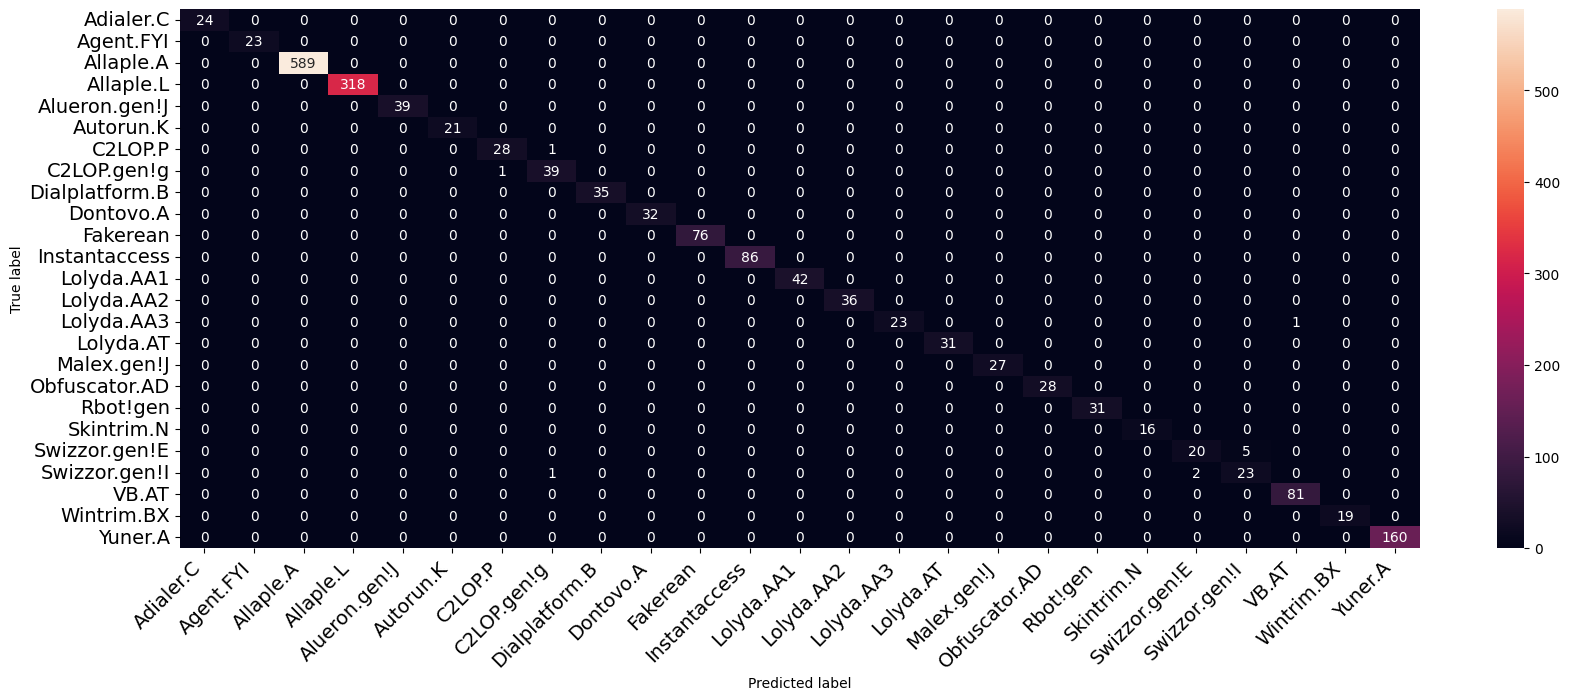

In [9]:
c_matrix = metrics.confusion_matrix(test_true_labels, test_predicted_labels)
df_confusion = pd.crosstab(test_true_labels, test_predicted_labels)
df_confusion.to_csv(os.path.join(data_path,"confusion_matrix.csv"))

confusion_matrix(c_matrix, classes, figsize = (20,7), fontsize=14)

In [10]:
report = metrics.classification_report(test_true_labels, test_predicted_labels, target_names=classes,  output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

                precision    recall  f1-score     support
Adialer.C        1.000000  1.000000  1.000000    24.00000
Agent.FYI        1.000000  1.000000  1.000000    23.00000
Allaple.A        1.000000  1.000000  1.000000   589.00000
Allaple.L        1.000000  1.000000  1.000000   318.00000
Alueron.gen!J    1.000000  1.000000  1.000000    39.00000
Autorun.K        1.000000  1.000000  1.000000    21.00000
C2LOP.P          0.965517  0.965517  0.965517    29.00000
C2LOP.gen!g      0.951220  0.975000  0.962963    40.00000
Dialplatform.B   1.000000  1.000000  1.000000    35.00000
Dontovo.A        1.000000  1.000000  1.000000    32.00000
Fakerean         1.000000  1.000000  1.000000    76.00000
Instantaccess    1.000000  1.000000  1.000000    86.00000
Lolyda.AA1       1.000000  1.000000  1.000000    42.00000
Lolyda.AA2       1.000000  1.000000  1.000000    36.00000
Lolyda.AA3       1.000000  0.958333  0.978723    24.00000
Lolyda.AT        1.000000  1.000000  1.000000    31.00000
Malex.gen!J   